# Exercise - Knowledge Base Agent - STARTER

In this exercise, you’ll implement and evaluate a RAG (Retrieval-Augmented Generation) pipeline, using RAGAS metrics and MLflow for logging the process.


**Challenge**

Your task is to create a LangGraph Workflow that includes:

- A RAG pipeline for information retrieval.
- An LLM-based judge for evaluation.
- RAGAS metrics for quality assessment.
- MLflow logging for observability.

The workflow should:

- Retrieve, augment, and generate answers.
- Evaluate the answers using RAGAS.
- Log performance metrics in MLflow.

## 0. Import the necessary libs

In [1]:
import os
import mlflow
from mlflow import log_params, log_metrics
from typing import List, Dict
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langchain_core.prompts import ChatPromptTemplate
from ragas import evaluate
from datasets import Dataset
from IPython.display import Image, display

## 1. Instantiate Chat Model with your API Key

To be able to connect with OpenAI, you need to instantiate an ChatOpenAI client passing your OpenAI key.

You can pass the `api_key` argument directly.
```python
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key="voc-",
)
```

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# TODO - Instantiate your chat model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    base_url="https://openai.vocareum.com/v1",
    api_key=os.getenv("VOCAREUM_OPENAI_API_KEY"),
)

In [4]:
# TODO - Instantiate your llm as judge model
# This will evaluate the responses
llm_judge = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0,
    base_url="https://openai.vocareum.com/v1",
    api_key=os.getenv("VOCAREUM_OPENAI_API_KEY"),
)

In [5]:
# TODO - Instantiate your embeddings model
embeddings_fn = OpenAIEmbeddings(
    model="text-embedding-3-large",
    base_url="https://openai.vocareum.com/v1",
    api_key=os.getenv("VOCAREUM_OPENAI_API_KEY"),
)

## 2. MLFlow

In [6]:
mlflow.set_tracking_uri("file:///Users/amundle/github/sandbox-udacity-ai-agents/mlruns")

In [7]:
mlflow.set_experiment("udacity")

/Users/amundle/github/sandbox-udacity-ai-agents/.venv/lib/python3.13/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/11/30 21:08:09 INFO mlflow.tracking.fluent: Experiment with name 'udacity' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/amundle/github/sandbox-udacity-ai-agents/mlruns/465881862363542514', creation_time=1764558489927, experiment_id='465881862363542514', last_update_time=1764558489927, lifecycle_stage='active', name='udacity', tags={}>

In [8]:
with mlflow.start_run(run_name="l4_exercise_02") as run:
    log_params(
        {
            "embeddings_model":embeddings_fn.model,
            "llm_model": llm.model_name,
            "llm_judge_model": llm_judge.model_name,
        }
    )
    print(run.info)

<RunInfo: artifact_uri='file:///Users/amundle/github/sandbox-udacity-ai-agents/mlruns/465881862363542514/00669e73fec24bc08d720d1f21860d49/artifacts', end_time=None, experiment_id='465881862363542514', lifecycle_stage='active', run_id='00669e73fec24bc08d720d1f21860d49', run_name='l4_exercise_02', start_time=1764558489964, status='RUNNING', user_id='amundle'>


In [9]:
mlflow_run_id = run.info.run_id

In [10]:
mflow_client = mlflow.tracking.MlflowClient()

In [11]:
mflow_client.get_run(mlflow_run_id)

<Run: data=<RunData: metrics={}, params={'embeddings_model': 'text-embedding-3-large',
 'llm_judge_model': 'gpt-4o',
 'llm_model': 'gpt-4o-mini'}, tags={'mlflow.runName': 'l4_exercise_02',
 'mlflow.source.name': '/Users/amundle/github/sandbox-udacity-ai-agents/.venv/lib/python3.13/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'amundle'}>, info=<RunInfo: artifact_uri='file:///Users/amundle/github/sandbox-udacity-ai-agents/mlruns/465881862363542514/00669e73fec24bc08d720d1f21860d49/artifacts', end_time=1764558489968, experiment_id='465881862363542514', lifecycle_stage='active', run_id='00669e73fec24bc08d720d1f21860d49', run_name='l4_exercise_02', start_time=1764558489964, status='FINISHED', user_id='amundle'>, inputs=<RunInputs: dataset_inputs=[], model_inputs=[]>, outputs=<RunOutputs: model_outputs=[]>>

## 3. Load and Process Documents

In [ ]:
# Initialize vector store
vector_store = Chroma(
    collection_name="udacity",
    embedding_function=embeddings_fn,
    api_key=os.getenv("VOCAREUM_OPENAI_API_KEY"),
    base_url="https://openai.vocareum.com/v1",
    model="text-embedding-ada-002"
)

# Load and process PDF documents
file_path = "compact-guide-to-large-language-models.pdf"
loader = PyPDFLoader(file_path)

pages = []
for page in loader.load():
    pages.append(page)

# Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, 
    chunk_overlap=200
)
all_splits = text_splitter.split_documents(pages)

# Store document chunks in the vector database
_ = vector_store.add_documents(documents=all_splits)


/var/folders/kl/80f0ft9x75q2x93y94lfw8800000gn/T/ipykernel_15106/1949086182.py:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  vector_store = Chroma(


## 4. Define State Schema

We define a State Schema for managing:

- MLFlow Run id
- User query
- Ground Truth
- Retrieved documents
- Generated answer
- Evaluation Report

run_id(str), ground_truth(str), evaluation(Dict),vquestion(str), documents(List) and answer(str)

In [13]:
# TODO - Create your state schema
# run_id(str), ground_truth(str), evaluation(Dict),vquestion(str), documents(List) and answer(str)
class State(MessagesState):
    run_id: str
    question: str
    ground_truth: str
    documents: List[Document]
    answer: str
    evaluation: Dict

## 5. RAG Nodes

The agent should:
- fetch relevant document chunks based on the user query
- combine the retrieved documents and use them as context
- invoke the LLM to generate a response
- evaluate the pipeline based on the ground_truth

In [14]:
def retrieve(state: State):
    question = state["question"]
    retrieved_docs = vector_store.similarity_search(question)
    return {"documents": retrieved_docs}

In [15]:
def augment(state: State):
    question = state["question"]
    documents = state["documents"]
    docs_content = "\n\n".join(doc.page_content for doc in documents)

    template = ChatPromptTemplate([
        ("system", "You are an assistant for question-answering tasks."),
        ("human", "Use the following pieces of retrieved context to answer the question. "
                "If you don't know the answer, just say that you don't know. " 
                "Use three sentences maximum and keep the answer concise. "
                "\n# Question: \n-> {question} "
                "\n# Context: \n-> {context} "
                "\n# Answer: "),
    ])

    messages = template.invoke(
        {"context": docs_content, "question": question}
    ).to_messages()

    return {"messages": messages}

In [16]:
def generate(state: State):
    ai_message = llm.invoke(state["messages"])
    return {"answer": ai_message.content, "messages": ai_message}

In [17]:
def evaluate_rag(state: State):
    question = state["question"]
    documents = state["documents"]
    answer = state["answer"]
    ground_truth = state["ground_truth"]
    dataset = Dataset.from_dict(
        {
            "question": [question],
            "answer": [answer],
            "contexts": [[doc.page_content for doc in documents]],
            "ground_truth": [ground_truth]
        }
    )

    evaluation_results = evaluate(
        dataset=dataset,
        llm=llm_judge
    )
    print(evaluation_results)

    # TODO - Log metrics in MLflow
    # The evaluation_results output value is a list
    # Example: evaluation_results["faithfulness"][0]
    with mlflow.start_run(state["run_id"]):
        log_metrics({
                "faithfulness": evaluation_results["faithfulness"],
                "context_precision": evaluation_results["context_precision"],
                "context_recall": evaluation_results["context_recall"],
                "answer_relevancy": evaluation_results["answer_relevancy"],

        })

    return {"evaluation": evaluation_results}

## 6. Build the LangGraph Workflow

In [18]:
     # TODO - add all the nodes and edges
workflow = StateGraph(State)

# Add nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("augment", augment)
workflow.add_node("generate", generate)
workflow.add_node("evaluate", evaluate_rag)

# Add edges to define the flow
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "augment")
workflow.add_edge("augment", "generate")
workflow.add_edge("generate", "evaluate")
workflow.add_edge("evaluate", END)

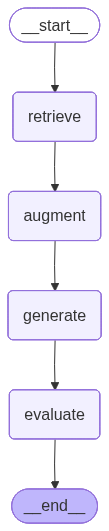

In [19]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

## 7. Invoke the Workflow with a Query

In [20]:
reference = [
    {
        "question": "What are Open source models?",
        "ground_truth": "Open-source models are AI or machine learning " 
                        "models whose code, architecture, and in some cases, " 
                        "training data and weights, are publicly available for " 
                        "use, modification, and distribution. They enable " 
                        "collaboration, transparency, and innovation by allowing " 
                        "developers to fine-tune, deploy, or improve them without " 
                        "proprietary restrictions.",
    }
]

In [21]:
output = graph.invoke(
    {
        "question": reference[0]["question"],
        "ground_truth": reference[0]["ground_truth"],
        "run_id": mlflow_run_id
    }
)

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

## 8. Inspect in MLFlow

In [ ]:
# TODO - Get MLFlow Run with .get_run()
mflow_client

## 9. Experiment

Now that you understood how it works, experiment with new things.

- Change RAG parameters: embedding model, chunk_size, chunk_overlap...
- Create multiple runs
- Improve your reference with more questions and ground_truth answers
- Use the results to understand what are the best parameters
- Create an Agent that picks the best combination